<a href="https://colab.research.google.com/github/charbull/diffusion_models/blob/main/diffusion_model_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The following colab attempts to highlight a few concepts and components in order to get an intuition behind [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239).  I found several code repositories online that I shamelessly copied from to make this colab:

* Original code: https://github.com/hojonathanho/diffusion/tree/master
* https://github.com/lucidrains/denoising-diffusion-pytorch
* https://colab.sandbox.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing
* Huggingface: https://huggingface.co/blog/annotated-diffusion

## More information

* step by step visual diffusion: https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models
* Blog about diffusion models with more in depth mathematical explanation: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

## Papers

* [Paper] Denoising Diffusion Probabilistic Models: https://arxiv.org/pdf/2006.11239 , [Paper code](https://github.com/hojonathanho/diffusion)
* [Paper] Unet https://arxiv.org/abs/1505.04597


In [1]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchvision

# Lets start with an image

Saving banana.jpeg to banana.jpeg


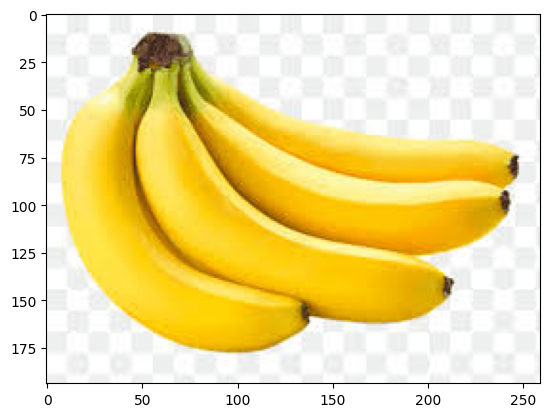

In [2]:
def upload_image():
    from google.colab import files
    import matplotlib.pyplot as plt

    # Upload the image
    uploaded = files.upload()

    image_path = list(uploaded.keys())[0]
    # Load and display the image
    image = plt.imread(image_path)[:,:,:3] # get the RGB instead of RGBA
    plt.imshow(image)
    plt.show()
    return image

image = upload_image()

In [3]:
image.shape

(194, 259, 3)

In [4]:
import torch
from torchvision import transforms
import numpy as np


def load_image_from_numpy(image_array):
  """
  Loads a NumPy array representing an image and applies basic transformations.

  Args:
    image_array: A NumPy array representing the image.

  Returns:
    A PyTorch tensor representing the transformed image.
  """
  image_size = 128

  # Define data transformations
  data_transforms = [
      transforms.ToTensor(), # Convert NumPy array to PyTorch tensor of shape CHW and divides by 255, scales to [0,1]
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] so that we can work with betas.
  ]
  data_transform = transforms.Compose(data_transforms)

  # Apply transformations
  transformed_image = data_transform(image_array)
  return transformed_image

In [5]:
transformed_image = load_image_from_numpy(image)

# Use the transformed image
x_zero = transformed_image.unsqueeze(0)
print(x_zero.shape)

torch.Size([1, 3, 128, 128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


# Forward diffusion process


## Intialize all the necessary parameters
First lets sample the betas (beta_t) and prepare all the constants used in the paper.

According to the paper, the forward diffusion process $q(x_t∣x_{t−1})$ which adds Gaussian noise at each timestep $t$ according to a known variance schedule
$0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ as:


\begin{equation}
q(x_t| x_{t-1}) = {N}( x_t;\sqrt{1-\beta_t}\ x_{t-1},\beta_t I)
\end{equation}

A Gaussian distribution is defined by 2 parameters: a mean $\mu$ and a variance
$\sigma^2 \ge 0$. Basically, each new (slightly noisier) image at timestep $t$
is drawn from a conditional Gaussian distribution with $\mu_t = \sqrt{1-\beta_t}\ x_{t-1}$ and $\sigma^2 = \beta_t$.


In the paper, the following parameters are set as as such:
* $\beta_1 = 1^{e-4}$
* $\beta_T = 0.02$
* noise_steps = 1000, we choose a smaller number just to visualize what is happening

beta controls the amount of noise we are adding to the image at a given step t.

In [6]:
noise_steps = 100

@torch.no_grad()
def prepare_linear_beta_t(beta_1=1e-4, beta_T=0.02, noise_steps=noise_steps):
  return torch.linspace(beta_1, beta_T, noise_steps)

beta_t = prepare_linear_beta_t(noise_steps=noise_steps)
beta_t.shape

torch.Size([100])

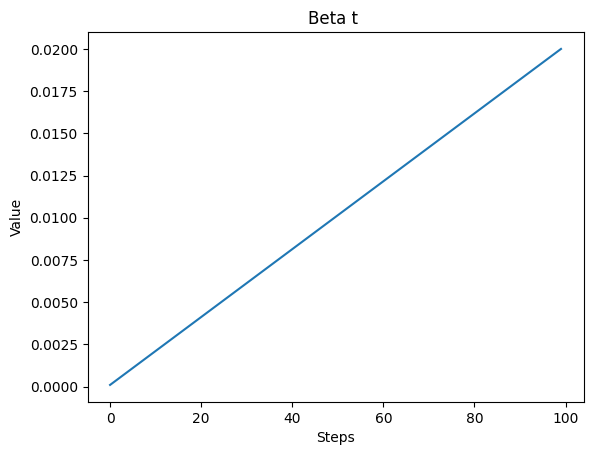

In [7]:
def plot_by_steps(tensor, title: str):
  t_numpy = tensor.numpy()
  plt.plot(t_numpy)
  plt.xlabel('Steps')
  plt.ylabel('Value')
  plt.title(title)
  plt.show()

plot_by_steps(beta_t, "Beta t ")

Note: In 2021 the following OpenAI paper [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) outlined that using a linear schedule is not that efficient. They proposed a cosine schedule.

Now that we have the betas, we can create the alphas and `alpha_hat` with their cumulative products along with their sqrt and other remaining operations.

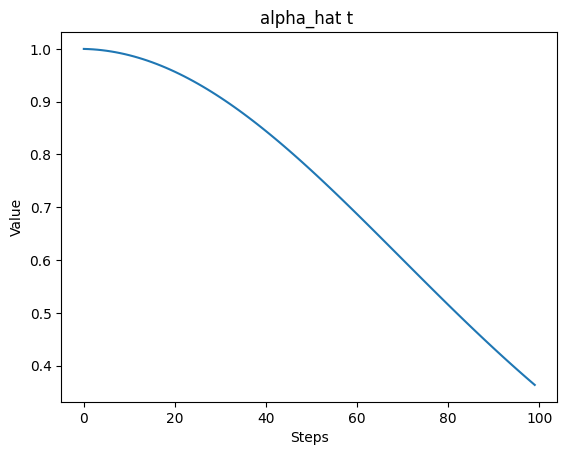

In [8]:
alpha_t = 1. - beta_t
alpha_hat = torch.cumprod(alpha_t, dim=0)
plot_by_steps(alpha_hat, "alpha_hat t ")

In [9]:
alpha_hat.shape

torch.Size([100])

In [10]:
timesteps = torch.arange(1, 100, 10)

In [11]:
sqrt_alpha_hat = torch.sqrt(alpha_hat[timesteps])
sqrt_alpha_hat

tensor([0.9998, 0.9928, 0.9759, 0.9497, 0.9150, 0.8725, 0.8237, 0.7697, 0.7119,
        0.6518])

## Let make some noise !

We are applying the same formula from the paper to get a new image with added noise from a previous image.

\begin{equation}
q(x_t| x_{t-1}) = {N}( x_t;\sqrt{1-\beta_t}\ x_{t-1},\beta_t I)
\end{equation}

To get the image $x_1$ at $t=1$ from image $x_0$ at $t=0$, we apply:
\begin{equation}
q(x_1| x_0) = {N}( x_1;\sqrt{1-\beta_t}\ x_0,\beta_1 I)
\end{equation}

To get the image $x_2$ at $t=2$ from image $x_1$ at $t=1$, we apply:
\begin{equation}
q(x_2| x_1) = {N}( x_2;\sqrt{1-\beta_t}\ x_1,\beta_2 I)
\end{equation}



Because the mean is changing between these steps, if we can calculate the **mean** of the entire process between $t=0$ and $t=T$ then we can write the entire formula in a way that will not depend on the previous steps but on $x_0$. After few reparametrization tricks explained in [step-by-step](https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models), the authors shows that we can depend only on the original image $x_0$:
\begin{equation}
x_t(x_0, \epsilon) =  \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t} \epsilon
\end{equation}

In [12]:
@torch.no_grad()
def noise_images(image_x0, timesteps: int, alpha_hat):
  sqrt_alpha_hat = torch.sqrt(alpha_hat[timesteps])[:, None, None, None]
  sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[timesteps])[:, None, None, None]
  noise = torch.randn_like(image_x0)
  return sqrt_alpha_hat * image_x0 + sqrt_one_minus_alpha_hat * noise

In [13]:
noised_images = noise_images(x_zero, timesteps, alpha_hat)
noised_images.shape

torch.Size([10, 3, 128, 128])

In [45]:
@torch.no_grad()
def show_tensor_image(image):
    """Applies the reverse transformations of the fn above and shows an image."""
    reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to , this is a common transformation from tensor back to image
    transforms.Lambda(lambda t: t * 255.), # scale back to 255
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # go to numpy universe
    transforms.ToPILImage(),  # Convert to PIL Image
  ])

    if len(image.shape) == 4: # ToPILImage goes to RGBA so we need to remove one dimension since RGBA has 4 dimensions
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

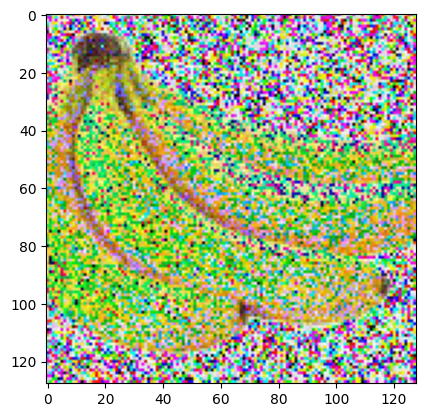

In [15]:
show_tensor_image(noised_images[2].squeeze())

Lets plot all images

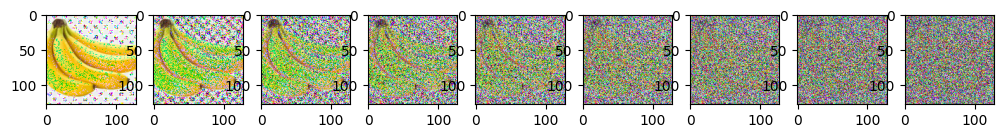

In [16]:
plt.figure(figsize=(15,15))
num_images = noised_images.shape[0]
for idx in range(0, num_images-1):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx) + 1)
    show_tensor_image(noised_images[t].squeeze())

In practice we dont need to go through all the timesteps of a image for training, we can just go from $x_0$ to $x_t$ very easily. This is why we want to sample the timestamps.

In [17]:
def sample_timesteps(n_samples, noise_steps):
  return torch.randint(low=1, high=noise_steps, size=(n_samples,))

timesteps = sample_timesteps(10, noise_steps)
timesteps

tensor([26, 19, 88, 69, 88, 23, 99, 27, 72, 13])

# Convolutional networks intuition

Before we go through the reverse diffusion, a quick intuition about convolutional networks, they are learned networks in the image/video processing domain checkout this blog for a quick explanation: [convolution explained](https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381)

Lets load an image of NYC skyline and apply some basic convolution with a edge detector `filter`.

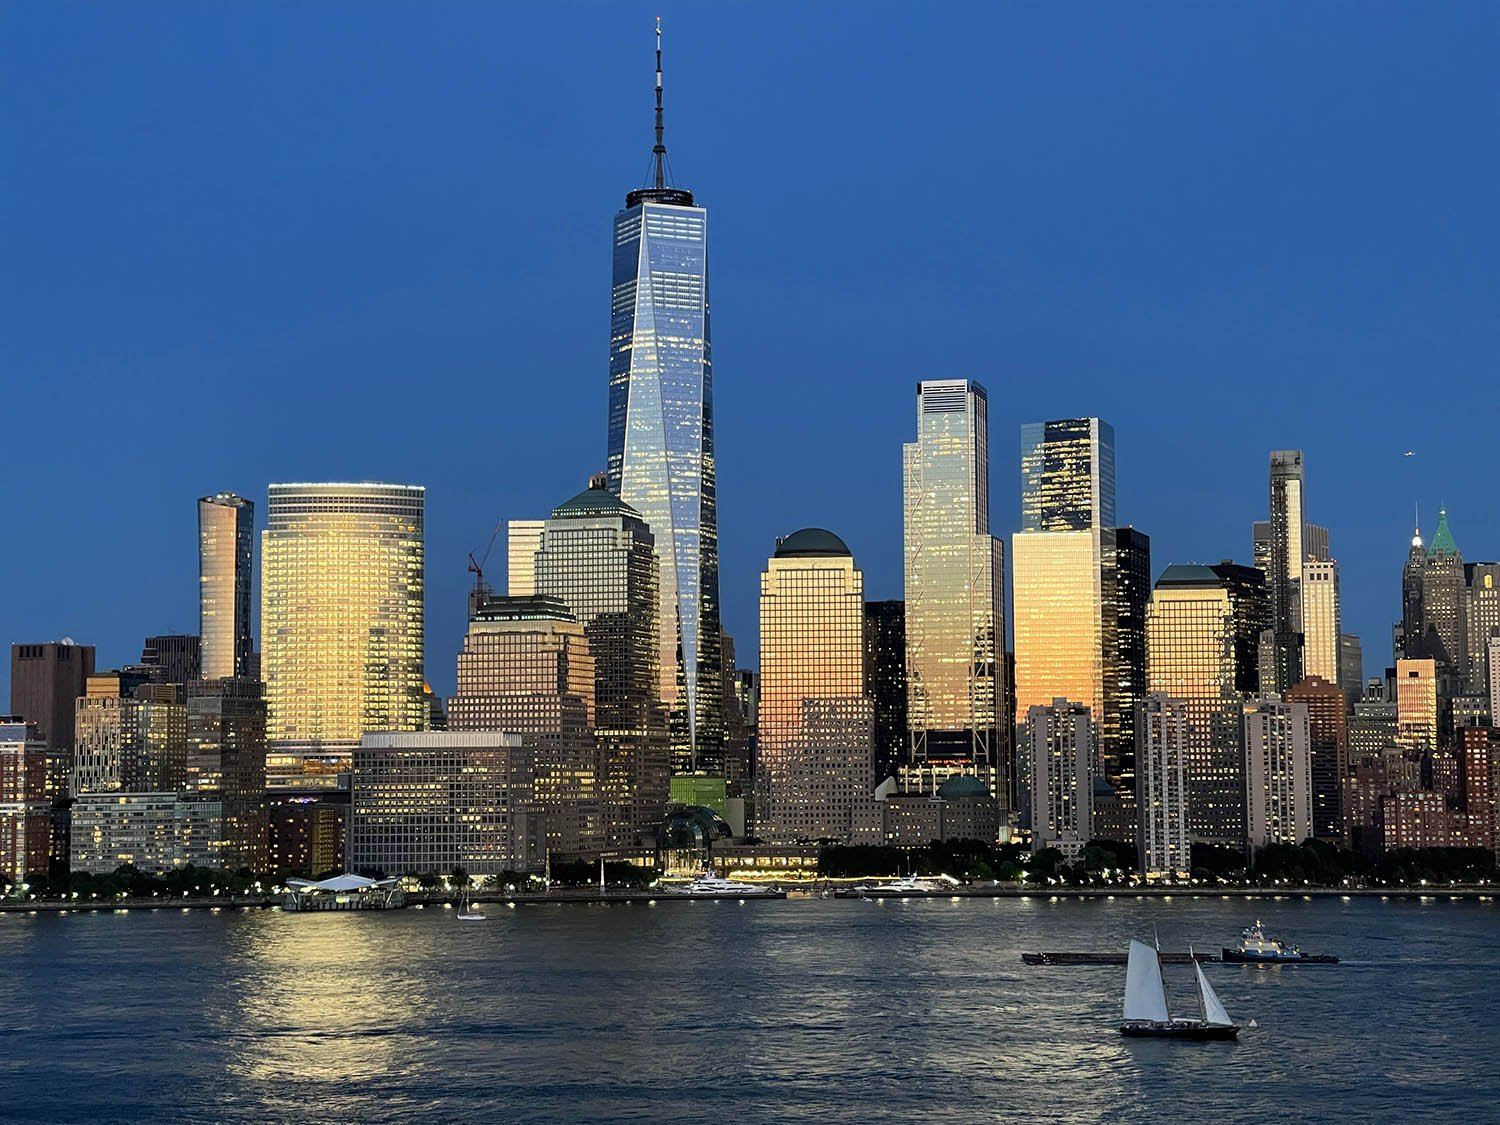

In [18]:
from PIL import Image
import requests
skyline_image_url = 'https://images.squarespace-cdn.com/content/v1/62015f66f840ef671da14ae7/4161edfa-ebba-4c13-90a4-90383f26260e/Photographing-NYC-skyline.jpg'
skyline_image = Image.open(requests.get(skyline_image_url, stream=True).raw)
skyline_image

We transform it to gray so that the filter works better on the edges

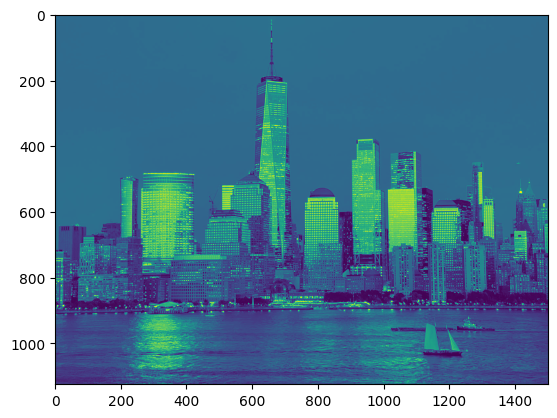

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import asarray



def rgb2gray(img):
    rgb = asarray(img)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


gray = rgb2gray(skyline_image)
plt.imshow(gray)
plt.show()

The code below is taken from: [convolutions.py](https://github.com/SamratSahoo/UT-Arlington-Research/blob/master/Week%206%20-%20Convolutions%20%26%20Wavelet%20Transforms/Convolutions.py)

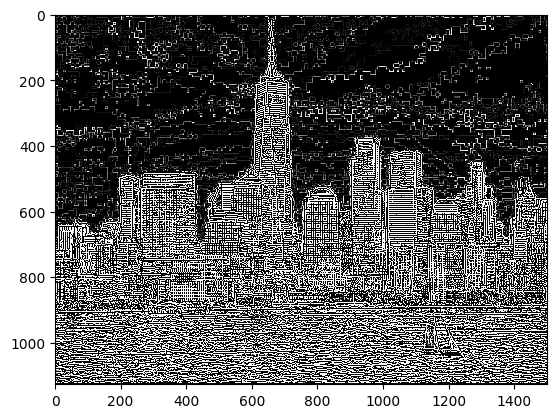

In [20]:
import numpy as np

def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

def apply_conv_filter(image):

    # Edge Detection Kernel
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

    # Convolve and Save Output
    output = convolve2D(image, kernel, padding=2)
    plt.imshow(output, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()


apply_conv_filter(gray)

The kernel used in the previous cell was fixed by hand at with `np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])` however, in a network those values are learned to detect features that are important to the objective function we are trying to optimize for.

# Reverse Diffusion
The convolution network and more specifically the U-net architecutre is used for the model training. Let's go through it
## U-net

Now that we gained some intuition about the convolutional networks, we will create a simple U-net model that we will train to predict the noise and remove it from an image.

For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


The input of the UNet is a noisy image and the ouput the noise in the image.

Because the parameters are shared accross time, we need to tell the network in which timestep we are. The Timestep is encoded by the transformer Sinusoidal Embedding

The code below is adapted from: [a-diffusion-model-from-scratch](https://medium.com/@amir.behbahanian/a-diffusion-model-from-scratch-cf1131988e78)


In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torchvision
from torchvision import transforms
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [2]:
def forward_diffusion_sample(image_x0, timesteps: int, alpha_hat, device):
  sqrt_alpha_hat = torch.sqrt(alpha_hat[timesteps])[:, None, None, None]
  sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[timesteps])[:, None, None, None]
  noise = torch.randn_like(image_x0)
  return sqrt_alpha_hat.to(device) * image_x0.to(device) + sqrt_one_minus_alpha_hat.to(device) * noise.to(device), noise.to(device)

In [3]:
mse = nn.MSELoss()

def get_loss(model, image_x0, timesteps, device):
    noisy_images, noise = forward_diffusion_sample(image_x0, timesteps, alpha_hat, device)
    noise_pred = model(noisy_images, timesteps)
    return mse(noise, noise_pred)

## Preparing the data
Now we need to load some data, torchvision has a flower dataset that we will train on.

In [4]:
@torch.no_grad()
def prepare_dataset():
  image_size = 128

  # Define data transformations
  data_transforms = [
      transforms.ToTensor(), # Convert NumPy array to PyTorch tensor of shape CHW and divides by 255, scales to [0,1]
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] so that we can work with betas.
  ]
  data_transform = transforms.Compose(data_transforms)
  train = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform)

  test = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform, split='test')
  return torch.utils.data.ConcatDataset([train, test])

In [5]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64


data = prepare_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 344862509/344862509 [00:17<00:00, 19665674.97it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 643306.02it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9032819.35it/s]


Helper functions from above so that we can run this section independently

In [22]:
@torch.no_grad()
def show_tensor_image(image):
    """Applies the reverse transformations of the fn above and shows an image."""
    reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to , this is a common transformation from tensor back to image
    transforms.Lambda(lambda t: t * 255.), # scale back to 255
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # go to numpy universe
    transforms.ToPILImage(),  # Convert to PIL Image
  ])

    if len(image.shape) == 4: # ToPILImage goes to RGBA so we need to remove one dimension since RGBA has 4 dimensions
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

@torch.no_grad()
def prepare_linear_beta_t(beta_1=1e-4, beta_T=0.02, noise_steps=100, device='cpu'):
  return torch.linspace(beta_1, beta_T, noise_steps).to(device)

@torch.no_grad()
def sample_timesteps(n_samples, noise_steps, device='cpu'):
  return torch.randint(low=1, high=noise_steps, size=(n_samples,)).to(device)


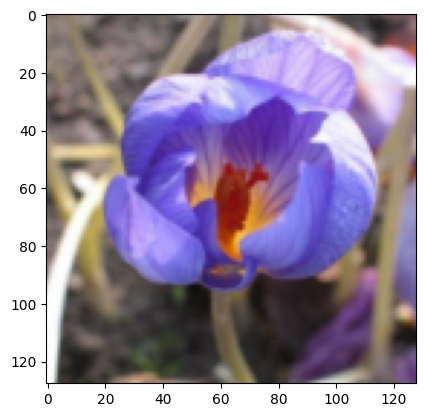

In [7]:
images = next(iter(dataloader))[0]
show_tensor_image(images)

In [8]:
images.shape

torch.Size([64, 3, 128, 128])

In [9]:
images[0].shape

torch.Size([3, 128, 128])

Add noise

In [10]:
noise_steps = 1000
beta_t = prepare_linear_beta_t(noise_steps=noise_steps)
alpha_t = 1. - beta_t
alpha_hat = torch.cumprod(alpha_t, dim=0)

In [15]:
timesteps = torch.arange(1, 150, 10)
noised_images, noise = forward_diffusion_sample(images[0], timesteps, alpha_hat, device='cpu')
noised_images.shape

torch.Size([15, 3, 128, 128])

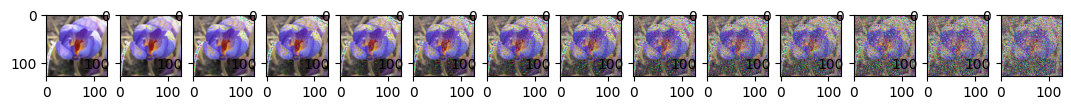

In [16]:
plt.figure(figsize=(15,15))
num_images = noised_images.shape[0]
for idx in range(0, num_images-1):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx) + 1)
    show_tensor_image(noised_images[t].squeeze())

## Training

(Wasn't able to get a successful run all the end, kept loosing the GPU)

In [17]:
infra = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(infra)
print(f' training on {device}')

 training on cuda


if we are training on cpu, we will train on a smaller subset

In [35]:
if infra == 'cpu':
  BATCH_SIZE = 64
  subset_indices = torch.arange(0, BATCH_SIZE, 1)
  subset = torch.utils.data.Subset(dataloader.dataset, subset_indices)
  dataloader = torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE)

 training on cuda
Starting epoch 0:


100%|██████████| 112/112 [03:56<00:00,  2.11s/it, MSE=0.0537]


Starting epoch 1:


100%|██████████| 112/112 [03:57<00:00,  2.12s/it, MSE=0.0316]


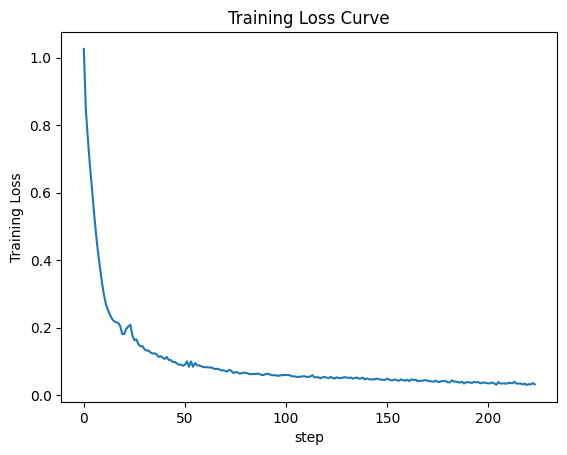

In [18]:
from torch.optim import Adam

infra = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(infra)
print(f' training on {device}')
noise_steps = 1000
beta_t = prepare_linear_beta_t(noise_steps=noise_steps, device=device)
alpha_t = 1. - beta_t
alpha_hat = torch.cumprod(alpha_t, dim=0).to(device)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 2 # Try more!
# T = 300
# we want to sample timesteps that corresponds to the number of images
timesteps = sample_timesteps(images.shape[0], noise_steps).to(device)

# Lists to store loss values
losses = []

for epoch in range(epochs):
    print(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for step, batch in enumerate(pbar):
      # Zero your gradients for every batch!
      optimizer.zero_grad()
      batch = batch[0].to(device)
      # Compute the loss and its gradients
      model.train(True)
      loss = get_loss(model, batch, timesteps, device)
      loss.backward()
       # Adjust learning weights
      optimizer.step()
      pbar.set_postfix(MSE=loss.item())

      # track loss
      losses.append(loss.item())


# Plot training loss
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

## Sampling

Now that the model learned all the parameters to predict the noise and remove it, lets try some samples.

\begin{equation}
      x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z
    \end{equation}


In [27]:
def sample(model, n, timesteps, device):
  print(f"Sampling {n} new images....")
  model.eval()
  img_size = 128
  noise_steps = 3000

  with torch.no_grad():
    x = torch.randn((n, 3, img_size, img_size)).to(device)
    original_image = x
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
      predicted_epsilon_noise = model(x, timesteps)
      alpha = alpha_t[timesteps][:, None, None, None]
      alpha_hat_t = alpha_hat[timesteps][:, None, None, None]
      beta = beta_t[timesteps][:, None, None, None]
      if i > 1:
        noise = torch.randn_like(x)
      elif i == 114 and infra == 'cpu':
        print("CPU is slow :P lets exit")
        break
      else:
        noise = torch.zeros_like(x)
      x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat_t))) * predicted_epsilon_noise) + torch.sqrt(beta) * noise
  model.train()
  x = (x.clamp(-1, 1) + 1) / 2
  x = (x * 255).type(torch.uint8)
  return x

In [28]:
generated_images = sample(model, BATCH_SIZE, timesteps, device)
generated_images.shape

Sampling 64 new images....


2999it [26:32,  1.88it/s]


torch.Size([64, 3, 128, 128])

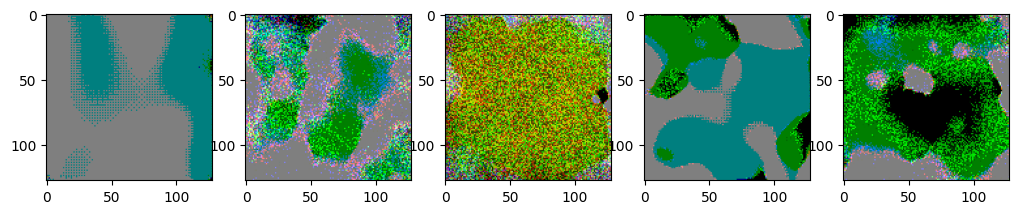

In [34]:
plt.figure(figsize=(15,15))
num_images = 5
random_int = np.random.randint(BATCH_SIZE, size=num_images)
for idx in range(0, num_images):
    t = torch.Tensor([random_int[idx]]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx) + 1)
    show_tensor_image(generated_images[t].squeeze())